# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# class Transforms:
#     def __init__(self, transforms: A.Compose):
#         self.transforms = transforms

#     def __call__(self, img, *args, **kwargs):
#         return self.transforms(image=np.array(img))

In [39]:

a_train_transforms = A.Compose([
    A.PadIfNeeded(min_height=36, min_width=36, always_apply=True, p=1),
    A.RandomCrop(height=32, width=32, always_apply=True, p=1),
    A.HorizontalFlip(p=0.5),
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8,always_apply=False,fill_value=(0.5, 0.5, 0.5)),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

a_test_transforms = A.Compose([
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

# Dataset and Creating Train/Test Split

In [40]:
# from utils import get_mnist_data
# train, test = get_mnist_data(train_transforms, test_transforms)
def get_augmentation(transforms):
    return lambda img: transforms(image=np.array(img))['image']
train = datasets.CIFAR10('./data', train=True, download=True, transform=get_augmentation(a_train_transforms))
test = datasets.CIFAR10('./data', train=False, download=True, transform=get_augmentation(a_test_transforms))

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [42]:
SEED = 27

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [43]:
len(train_loader)

98

# The model
Let's start with the model we first saw

In [51]:
import torch.nn.functional as F
dropout_value = 0.05
class CustomResnet(nn.Module):
    def __init__(self):
        super(CustomResnet, self).__init__()
        self.prep_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, bias=False), #input 3x32x32 output 64x32x32 RF 3X3
            nn.ReLU(),
            nn.BatchNorm2d(64),
            #nn.Dropout(dropout_value),
        )

        # Conv Block 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), #input 128x17x17 Output 128x15x15 RF 10X10
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            #nn.Dropout(dropout_value),
        )

        # Res Block 1
        self.res_block1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), #input 3x32x32 output 64x32x32 RF 3X3
            nn.ReLU(),
            nn.BatchNorm2d(128),
            #nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False), #input 3x32x32 output 64x32x32 RF 3X3
            nn.ReLU(),
            nn.BatchNorm2d(128),
            #nn.Dropout(dropout_value),
        )

        #Conv Block 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False), #input 128x17x17 Output 128x15x15 RF 10X10
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            #nn.Dropout(dropout_value),
        )

        # Conv Block 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1, bias=False), #input 128x17x17 Output 128x15x15 RF 10X10
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            #nn.Dropout(dropout_value),
        )

        # Res Block 3
        self.res_block3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False), #input 3x32x32 output 64x32x32 RF 3X3
            nn.ReLU(),
            nn.BatchNorm2d(512),
            #nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, bias=False), #input 3x32x32 output 64x32x32 RF 3X3
            nn.ReLU(),
            nn.BatchNorm2d(512),
            #nn.Dropout(dropout_value),
        )

        self.mp = nn.MaxPool2d(4,2) #input 128x8x8 Output 128x1x1 RF  238X238
        self.output = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=10, kernel_size=(1, 1), padding=0, bias=False), #input 128x1x1 Output 64x1X1 RF 238X238
        )

    def forward(self, x):
        x = self.prep_layer(x)
        x = self.convblock1(x)
        r1 = self.res_block1(x)
        x = x + r1
        x = self.convblock2(x)
        x = self.convblock3(x)
        r3 = self.res_block3(x)
        x = x + r3
        x = self.mp(x)
        x = self.output(x)
        x = x.view(-1, 10)
        return x

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [52]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CustomResnet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
              ReLU-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,456
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         147,456
             ReLU-12          [-1, 128, 16, 16]               0
      BatchNorm2d-13          [-1, 128, 16, 16]             256
           Conv2d-14          [-1,

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [68]:
# from utils import train, test



from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer,scheduler, epoch,criterion):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [54]:
!pip install torch-lr-finder

In [55]:
len(train_loader)

98

  0%|          | 0/98 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.52E-01


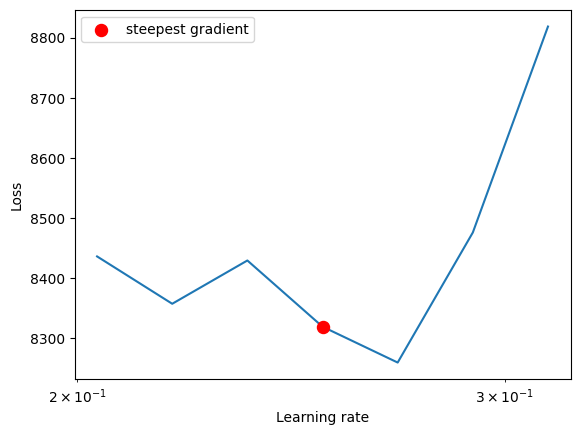

In [59]:
from torch_lr_finder import LRFinder

model =  CustomResnet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.1,weight_decay = 1e-4)
criterion = nn.CrossEntropyLoss(reduction='sum')
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=len(train_loader))
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [69]:
from torch.optim.lr_scheduler import OneCycleLR

model =  CustomResnet().to(device)
optimizer = optim.Adam(model.parameters(), lr=8e-04,weight_decay = 1e-4)
scheduler = OneCycleLR(optimizer, max_lr=8e-02, steps_per_epoch=len(train_loader), epochs=24,div_factor=100,pct_start = 5/24)
criterion = nn.CrossEntropyLoss(reduction='sum')

EPOCHS = 24
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer,scheduler,epoch,criterion)
    # scheduler.step()
    test(model, device, test_loader,criterion)

EPOCH: 0


Loss=383.9819641113281 Batch_id=97 Accuracy=46.82: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]



Test set: Average loss: 1.5838, Accuracy: 5235/10000 (52.35%)

EPOCH: 1


Loss=381.7080078125 Batch_id=97 Accuracy=60.70: 100%|██████████| 98/98 [00:22<00:00,  4.36it/s]



Test set: Average loss: 1.5014, Accuracy: 5821/10000 (58.21%)

EPOCH: 2


Loss=247.68038940429688 Batch_id=97 Accuracy=70.16: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]



Test set: Average loss: 0.8162, Accuracy: 7250/10000 (72.50%)

EPOCH: 3


Loss=228.34890747070312 Batch_id=97 Accuracy=76.50: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]



Test set: Average loss: 0.8448, Accuracy: 7395/10000 (73.95%)

EPOCH: 4


Loss=223.6309051513672 Batch_id=97 Accuracy=78.16: 100%|██████████| 98/98 [00:22<00:00,  4.31it/s]



Test set: Average loss: 0.7477, Accuracy: 7558/10000 (75.58%)

EPOCH: 5


Loss=235.10731506347656 Batch_id=97 Accuracy=80.82: 100%|██████████| 98/98 [00:21<00:00,  4.66it/s]



Test set: Average loss: 0.6184, Accuracy: 7953/10000 (79.53%)

EPOCH: 6


Loss=155.18682861328125 Batch_id=97 Accuracy=82.64: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.6126, Accuracy: 7989/10000 (79.89%)

EPOCH: 7


Loss=136.03294372558594 Batch_id=97 Accuracy=83.90: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.5151, Accuracy: 8326/10000 (83.26%)

EPOCH: 8


Loss=173.8176727294922 Batch_id=97 Accuracy=85.76: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]



Test set: Average loss: 0.5134, Accuracy: 8388/10000 (83.88%)

EPOCH: 9


Loss=130.99578857421875 Batch_id=97 Accuracy=86.93: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]



Test set: Average loss: 0.4721, Accuracy: 8482/10000 (84.82%)

EPOCH: 10


Loss=139.20460510253906 Batch_id=97 Accuracy=88.15: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]



Test set: Average loss: 0.4279, Accuracy: 8651/10000 (86.51%)

EPOCH: 11


Loss=83.37470245361328 Batch_id=97 Accuracy=89.04: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]



Test set: Average loss: 0.4235, Accuracy: 8695/10000 (86.95%)

EPOCH: 12


Loss=69.5301513671875 Batch_id=97 Accuracy=90.62: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]



Test set: Average loss: 0.3881, Accuracy: 8807/10000 (88.07%)

EPOCH: 13


Loss=112.80442810058594 Batch_id=97 Accuracy=91.41: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4039, Accuracy: 8807/10000 (88.07%)

EPOCH: 14


Loss=56.05730056762695 Batch_id=97 Accuracy=92.83: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.3458, Accuracy: 8974/10000 (89.74%)

EPOCH: 15


Loss=54.8376350402832 Batch_id=97 Accuracy=93.70: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]



Test set: Average loss: 0.3641, Accuracy: 9000/10000 (90.00%)

EPOCH: 16


Loss=49.5455436706543 Batch_id=97 Accuracy=94.60: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]



Test set: Average loss: 0.3282, Accuracy: 9063/10000 (90.63%)

EPOCH: 17


Loss=40.03893280029297 Batch_id=97 Accuracy=95.67: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]



Test set: Average loss: 0.3049, Accuracy: 9143/10000 (91.43%)

EPOCH: 18


Loss=55.41444396972656 Batch_id=97 Accuracy=96.48: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.3167, Accuracy: 9144/10000 (91.44%)

EPOCH: 19


Loss=21.625242233276367 Batch_id=97 Accuracy=97.33: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.2996, Accuracy: 9183/10000 (91.83%)

EPOCH: 20


Loss=19.677082061767578 Batch_id=97 Accuracy=97.80: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]



Test set: Average loss: 0.2935, Accuracy: 9208/10000 (92.08%)

EPOCH: 21


Loss=18.047760009765625 Batch_id=97 Accuracy=98.04: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]



Test set: Average loss: 0.2856, Accuracy: 9244/10000 (92.44%)

EPOCH: 22


Loss=23.210203170776367 Batch_id=97 Accuracy=98.28: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]



Test set: Average loss: 0.2852, Accuracy: 9248/10000 (92.48%)

EPOCH: 23


Loss=12.291866302490234 Batch_id=97 Accuracy=98.50: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.2849, Accuracy: 9242/10000 (92.42%)



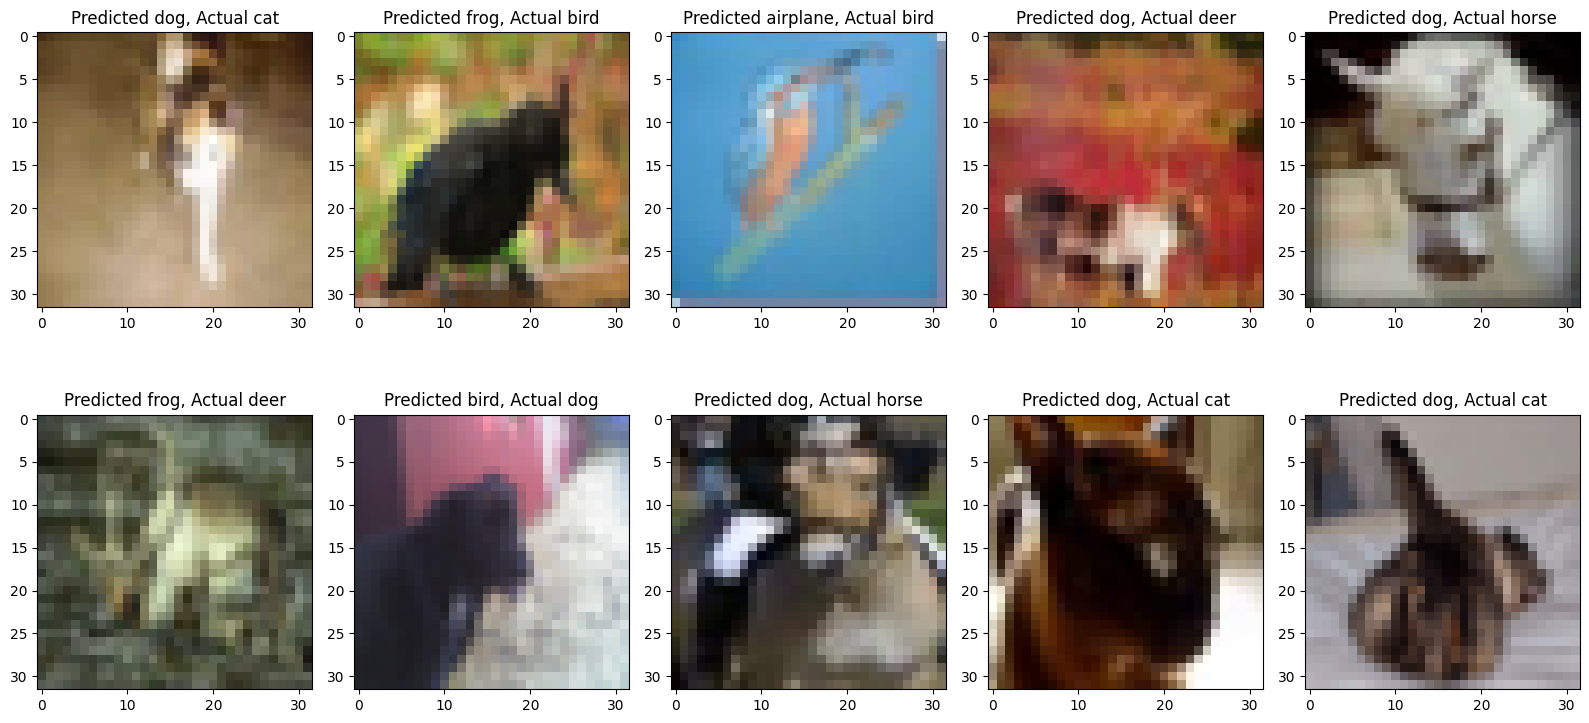

In [70]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_incorrect_images(model,test_loader,n=10):
  incorrect_images = []
  predicted_labels = []
  correct_labels = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    incorrect_items = pred.ne(target.view_as(pred))
    incorrect_indices = incorrect_items.view(-1).nonzero().view(-1)
    predicted_labels.extend([item.item() for item in pred[incorrect_indices[:n-len(incorrect_images)]]])
    correct_labels.extend([item.item() for item in target.view_as(pred)[incorrect_indices[:n-len(incorrect_images)]]])
    incorrect_images.extend([item for item in data[incorrect_indices[:n-len(incorrect_images)]]])
    if len(incorrect_images)==n:
      break
  return incorrect_images,predicted_labels,correct_labels

def imshow(img):
  img = img / 2 + 0.5     # Unnormalize
  npimg = img
  npimg = np.clip(npimg, 0, 1)  # Add this line to clip the values
  return np.transpose(npimg, (1, 2, 0))  # Convert from Tensor image

fig, axes = plt.subplots(2, 5, figsize=(16, 8))

incorrect_images,predicted_labels,correct_labels = get_incorrect_images(model,test_loader,n=10)

for i, image_tensor in enumerate(incorrect_images):
    ax = axes[i // 5, i % 5]  # Get the location of the subplot
    image = image_tensor.cpu().numpy()
    ax.imshow(imshow(image))  # Display the image
    ax.set_title(f"Predicted {class_names[predicted_labels[i]]}, Actual {class_names[correct_labels[i]]}")  # Set the title as the index

plt.tight_layout()  # To provide sufficient spacing between subplots
plt.show()